## Dependancies

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import pyreadr as pyr
import pandas as pd
import tqdm
import json
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import scipy
import statsmodels
import gseapy as gp
import pyensembl as pe
import lifelines
from lifelines import CoxPHFitter
import statsmodels
from statsmodels.stats.multitest import multipletests
import sksurv
from sksurv.linear_model import CoxnetSurvivalAnalysis
import umap.umap_ as umap
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from itertools import combinations
from lifelines.statistics import logrank_test
from lifelines import KaplanMeierFitter
import joblib

print(matplotlib.__version__)
print(np.__version__)
print(pd.__version__)
print(pyr.__version__)
print(tqdm.__version__)
print(json.__version__)
print(sklearn.__version__)
print(sns.__version__)
print(scipy.__version__)
print(statsmodels.__version__)
print(gp.__version__)
print(pe.__version__)
print(lifelines.__version__)
print(statsmodels.__version__)
print(sksurv.__version__)
print(joblib.__version__)

## Data Import

In [2]:
TE = pyr.read_r('InputData/TCGA/RE_all_2_counts_normalized.RDS')[None]
Gene = pyr.read_r('InputData/TCGA/GENE_2_counts_normalized.RDS')[None]
clinical = pd.read_csv('InputData/TCGA/metadata.csv', index_col=0)

In [3]:
data = pe.EnsemblRelease(77)

for i in Gene.index:
    try:
        Gene.loc[i, 'gene_name'] = data.gene_name_of_gene_id(i)
    except:
        Gene.loc[i, 'gene_name'] = None
Gene.dropna(subset=['gene_name'], inplace=True)
Gene.index = Gene['gene_name']
Gene.drop(columns=['gene_name'], inplace=True)

ENSEMBL IDs were converted to GENECODE21 gene names

In [4]:
TumourGene = Gene.loc[:, clinical[clinical['definition'] != 'Solid Tissue Normal'].index]
TumourTE = TE.loc[:, clinical[clinical['definition'] != 'Solid Tissue Normal'].index]
print('Tumour Gene shape:', TumourGene.shape)
print('Tumour TE shape:', TumourTE.shape)

Tumour Gene shape: (55814, 412)
Tumour TE shape: (1052, 412)


## BCTE Classifier

This section details the methods used to derive the BCTE classifier. This classifier was optimized to deliniate the tumour derived transposable elements transcriptional expression most predictive of outcome for bladder cancer patients, termed 'prognostic elements'. These 'prognostic elements' are then used to construct a classifier (random forest) that predicts the overall survival (and other associated outcomes) for bladder cancer patients.

### Feature Selection Workflow

To isolate transposable element (TE) features most strongly associated with patient outcome, the following stepwise approach was implemented:

1. **Feature Standardization**  
   The filtered features were standardized using **z-score scaling (`StandardScaler`)**, ensuring that each feature contributed equally to the penalized regression model.  
   - This transformation sets each feature to have a mean of 0 and a standard deviation of 1.

2. **Univariate Cox Proportional Hazards Modeling**  
   Each feature was independently evaluated for its association with survival using **univariate Cox proportional hazards (PH) models**.  
   - This served as an initial filtering step to identify features with significant univariate prognostic value.

3. **LASSO-Penalized Cox Regression**  
   To identify features with the strongest **multivariate** association with survival, a **LASSO-penalized Cox regression model** was applied.  
   - The regularization parameter (\(\alpha\)) was optimized via internal cross-validation.
   - Only features with non-zero coefficients were retained, representing those with independent prognostic relevance after controlling for correlated effects.


#### Feature Standardization and Filtering

The first filtering step applied was univariate cox modeling. If a feature (TE expression) is univariately related to overall survival it will be included in following steps.

In [5]:
TCGA_surv = clinical.loc[clinical[clinical['definition'] != 'Solid Tissue Normal'].index, ['days_to_last_follow_up', 'days_to_death', 'vital_status']]

for patient in TCGA_surv.index:
    if TCGA_surv.loc[patient, 'vital_status'] == 'Dead':
        TCGA_surv.loc[patient, 'vital'] = 1
        TCGA_surv.loc[patient, 'days_survival'] = TCGA_surv.loc[patient, 'days_to_death']
    else:
        TCGA_surv.loc[patient, 'vital'] = 0
        TCGA_surv.loc[patient, 'days_survival'] = TCGA_surv.loc[patient, 'days_to_last_follow_up']

TCGA_surv.drop(['days_to_last_follow_up', 'days_to_death', 'vital_status'], axis=1, inplace=True)

StandardScaler is used to normalize the features (TE expression) to have a mean=0 and a std=1. I also do not want features that are in the bottom 10% in transcriptional expression to be influential in the final model. As a result, they are filtered from consideration. 

In [6]:
scaler = StandardScaler()
TE_scaled = pd.DataFrame(scaler.fit_transform(TumourTE.T), index=TumourTE.columns, columns=TumourTE.index).T

threshold = TE_scaled.T.median().quantile(0.1)
filtered_TEs = TE_scaled.T.columns[TE_scaled.T.median() > threshold]
TE_filtered = TE_scaled.T[filtered_TEs].T
TCGA_surv = TCGA_surv.loc[TE_filtered.columns, :].T

In some instances, negative and NaN values were input for overall survival. As such, these patients to dont meet the criteria needed for further assessment. The IDs for these samples are listed below. 

In [7]:
TCGA_surv.loc['days_survival', 'TCGA-GD-A76B-01A-11R-A32O-07'] = 224
TCGA_surv.drop(['TCGA-GV-A3QG-01A-11R-A220-07',
                'TCGA-UY-A8OC-01A-11R-A36F-07',
                'TCGA-GC-A6I1-01A-12R-A31N-07',
                'TCGA-CF-A9FH-01A-11R-A38B-07',
                'TCGA-GC-A6I3-01A-11R-A31N-07'],
                  axis=1, inplace=True)
TE_filtered.drop(['TCGA-GV-A3QG-01A-11R-A220-07',
                  'TCGA-UY-A8OC-01A-11R-A36F-07',
                  'TCGA-GC-A6I1-01A-12R-A31N-07',
                  'TCGA-CF-A9FH-01A-11R-A38B-07',
                  'TCGA-GC-A6I3-01A-11R-A31N-07'],
                    axis=1, inplace=True)
df = pd.concat([TE_filtered, TCGA_surv], axis=0).T

#### Univariate Cox Proportional Hazard Modeling

In [ ]:
from lifelines import CoxPHFitter
from statsmodels.stats.multitest import multipletests

cph = CoxPHFitter()

univariate_results = [['TE', 'p_value']]

for te in TE_filtered.index:

    cph.fit(df[[te, 'days_survival', 'vital']], duration_col='days_survival', event_col='vital')
    p_value = cph.summary.loc[te, 'p']
    univariate_results.append([te, p_value])

univariate_results = pd.DataFrame(univariate_results[1:], columns=univariate_results[0])
univariate_results['FDR'] = multipletests(univariate_results['p_value'], method='fdr_bh')[1]
significant_TEs = univariate_results[univariate_results['FDR'] < 0.05]['TE'].values.tolist()

In [ ]:
univariate_results.sort_values('FDR').to_csv('Results/TCGA_UnivariateCOX.csv')
print(len(significant_TEs), 'TEs are significant in univariate analysis')

73 TEs are significant in univariate analysis


#### LASSO-Penalized Cox Regression

**Penalized Cox regression** is a regularized extension of the traditional Cox proportional hazards model, commonly used for modeling time-to-event (survival) data. It is particularly valuable in high-dimensional settings, where the number of candidate features may be large relative to the number of observations.

In this analysis, we applied a **LASSO-penalized Cox regression**, which adds an L1 penalty term to the loss function. This encourages sparsity in the model by shrinking less informative feature coefficients toward zero. 

**Why this is useful for feature selection:**
- **Reduces dimensionality** by selecting only the most informative features
- **Controls overfitting**, especially in datasets with many collinear or irrelevant variables
- **Enhances model interpretability** by producing a sparse solution (many coefficients are exactly zero)

The optimal value of \(\lambda\) is typically selected through internal cross-validation. Features with non-zero coefficients in the penalized model are considered to have **independent prognostic value** and are carried forward for downstream modeling or interpretation.


In [ ]:
TE_filtered = TE_filtered.T

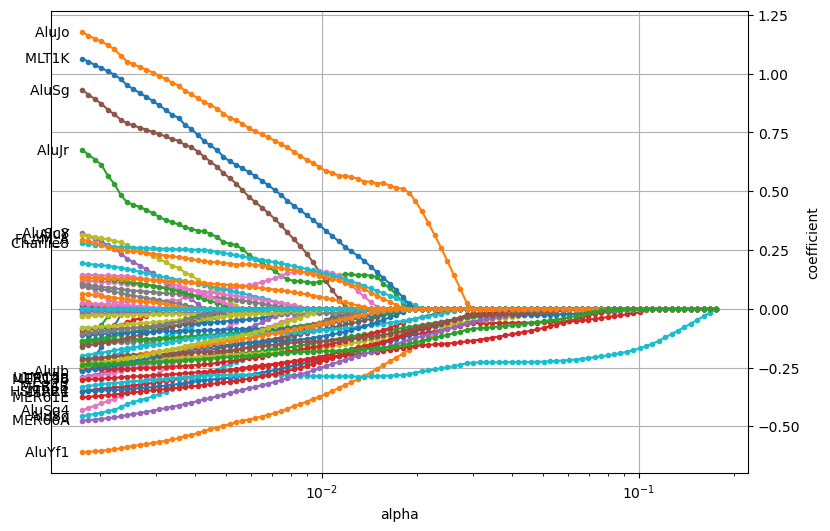

In [ ]:
y_structured = np.array([(bool(event), time) for event, time in zip(df['vital'], df['days_survival'])],
                        dtype=[('vital', 'bool'), ('days_survival', 'float')])

cox_lasso = CoxnetSurvivalAnalysis(l1_ratio=1.0, alpha_min_ratio=0.01)
cox_lasso.fit(TE_filtered[significant_TEs], y_structured)

def plot_coefficients(coefs, n_highlight):
    _, ax = plt.subplots(figsize=(9, 6))
    alphas = coefs.columns
    for row in coefs.itertuples():
        ax.semilogx(alphas, row[1:], ".-", label=row.Index)

    alpha_min = alphas.min()
    top_coefs = coefs.loc[:, alpha_min].map(abs).sort_values().tail(n_highlight)
    for name in top_coefs.index:
        coef = coefs.loc[name, alpha_min]
        plt.text(alpha_min, coef, name + "   ", horizontalalignment="right", verticalalignment="center")

    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    ax.grid(True)
    ax.set_xlabel("alpha")
    ax.set_ylabel("coefficient")

coefficients_lasso = pd.DataFrame(cox_lasso.coef_, index=TE_filtered[significant_TEs].columns, columns=np.round(cox_lasso.alphas_, 5))

plot_coefficients(coefficients_lasso, n_highlight=20)

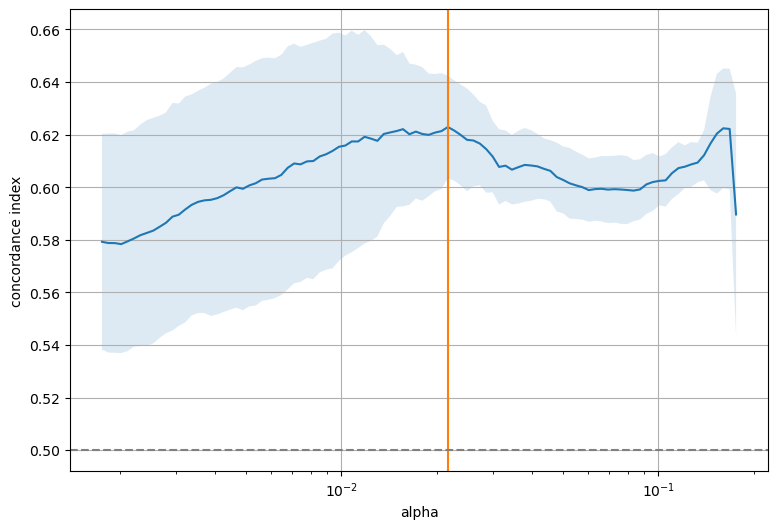

In [ ]:
import warnings
from sklearn.pipeline import make_pipeline
from sklearn.exceptions import FitFailedWarning
from sklearn.model_selection import KFold, GridSearchCV

coxnet_pipe = make_pipeline(StandardScaler(), CoxnetSurvivalAnalysis(l1_ratio=1.0, alpha_min_ratio=0.01, max_iter=100))
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", FitFailedWarning)
coxnet_pipe.fit(TE_filtered[significant_TEs], y_structured)

estimated_alphas = coxnet_pipe.named_steps["coxnetsurvivalanalysis"].alphas_
cv = KFold(n_splits=5, shuffle=True, random_state=0)
gcv = GridSearchCV(
    make_pipeline(StandardScaler(), CoxnetSurvivalAnalysis(l1_ratio=0.9)),
    param_grid={"coxnetsurvivalanalysis__alphas": [[v] for v in estimated_alphas]},
    cv=cv,
    error_score=0.5,
    n_jobs=1,
).fit(TE_filtered[significant_TEs], y_structured)

cv_results = pd.DataFrame(gcv.cv_results_)

alphas = cv_results.param_coxnetsurvivalanalysis__alphas.map(lambda x: x[0])
mean = cv_results.mean_test_score
std = cv_results.std_test_score

fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(alphas, mean)
ax.fill_between(alphas, mean - std, mean + std, alpha=0.15)
ax.set_xscale("log")
ax.set_ylabel("concordance index")
ax.set_xlabel("alpha")
ax.axvline(gcv.best_params_["coxnetsurvivalanalysis__alphas"][0], c="C1")
ax.axhline(0.5, color="grey", linestyle="--")
ax.grid(True)

Number of non-zero coefficients: 16


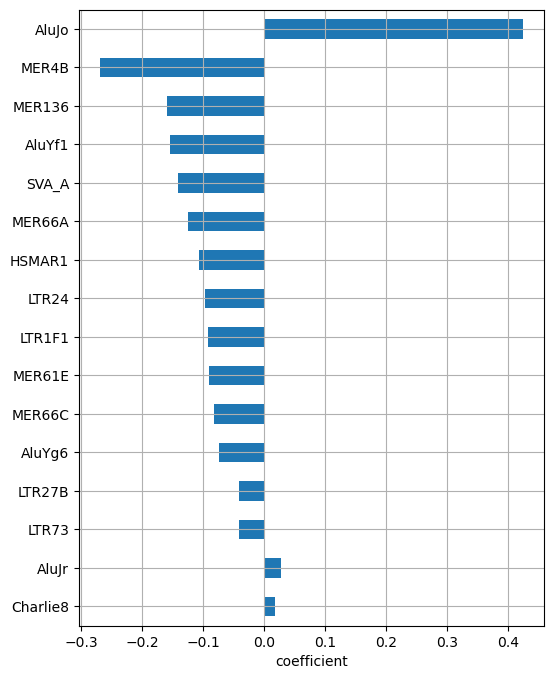

In [ ]:
best_model = gcv.best_estimator_.named_steps["coxnetsurvivalanalysis"]
best_coefs = pd.DataFrame(best_model.coef_, index=TE_filtered[significant_TEs].columns, columns=["coefficient"])

non_zero = np.sum(best_coefs.iloc[:, 0] != 0)
print(f"Number of non-zero coefficients: {non_zero}")

non_zero_coefs = best_coefs.query("coefficient != 0")
coef_order = non_zero_coefs.abs().sort_values("coefficient").index

_, ax = plt.subplots(figsize=(6, 8))
non_zero_coefs.loc[coef_order].plot.barh(ax=ax, legend=False)
ax.set_xlabel("coefficient")
ax.grid(True)

In [ ]:
coxnet_pred = make_pipeline(StandardScaler(), CoxnetSurvivalAnalysis(l1_ratio=1, fit_baseline_model=True))
coxnet_pred.set_params(**gcv.best_params_)
coxnet_pred.fit(TE_filtered[significant_TEs], y_structured)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('coxnetsurvivalanalysis',
                 CoxnetSurvivalAnalysis(alphas=[0.021663454070429813],
                                        fit_baseline_model=True, l1_ratio=1))])

In [ ]:
coxnet_model = coxnet_pred.named_steps['coxnetsurvivalanalysis']
final_coefs = pd.DataFrame(coxnet_model.coef_, index=TE_filtered[significant_TEs].columns, columns=['coefficient'])
lasso_sig_TE = final_coefs[final_coefs['coefficient'] != 0].index.values.tolist()

In [ ]:
clustering_data = TE.loc[lasso_sig_TE, :].T
clustering_data.to_csv('InputData/TCGA/LASSO_features_TCGA_TE.csv')

### BCTE Cluster Assignment

Unsupervised clustering enables the discovery of intrinsic structure in high-dimensional data without relying on pre-defined labels. This is particularly useful for identifying potential disease subtypes or prognostic groups in an unbiased manner.

In this analysis, we applied a UMAP-based hierarchical clustering approach, followed by survival modeling to assess clinical relevance.

Steps performed:

StandardScaler normalization was first applied to all input features to ensure uniform scaling across dimensions.

UMAP was used for dimensionality reduction, capturing the local structure of the data while enabling efficient visualization and clustering in a low-dimensional space.

Hierarchical clustering (Ward linkage) was performed on the UMAP-reduced representation to group samples based on similarity.

The optimal number of clusters was selected by maximizing the average silhouette score, which quantifies cohesion within clusters and separation between them.

Kaplan-Meier survival analysis was used to evaluate differences in clinical outcomes across the resulting clusters, confirming that these subgroups had prognostic significance.

Why this is useful for downstream classification:

Reveals underlying patient subgroups that may correspond to molecular or clinical phenotypes

Provides cluster labels that can be used as outcome classes in supervised models (e.g., random forest)

Enables survival-informed feature learning, allowing identification of features associated with clinically meaningful differences

These unsupervised clusters were ultimately used as target classes in a random forest classifier, enabling supervised prediction of cluster membership based on molecular input features.

In [ ]:
clustering_data = pd.read_csv('InputData/TCGA/LASSO_features_TCGA_TE.csv', index_col=0)

scaler = StandardScaler()

# Fit and transform the data
clustering_data_scaled = pd.DataFrame(scaler.fit_transform(clustering_data),
                                      columns=clustering_data.columns,
                                      index=clustering_data.index)

UMAP was used to reduce the dimensionality of the scaled prognostic TEs as it maintains local structure in the data. As such, clusters or phenotypes in the data will emerge and will be highlighted. 

/opt/anaconda3/envs/SubtypeSwitch/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


(412, 2)


<Axes: xlabel='UMAP1', ylabel='UMAP2'>

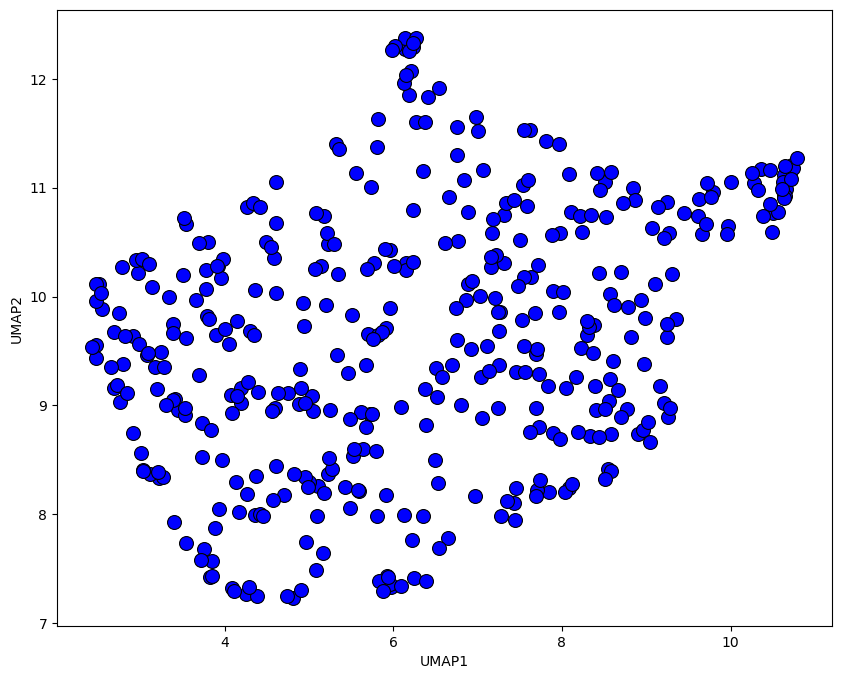

In [ ]:
umap_reducer = umap.UMAP(
    n_neighbors=15,    
    min_dist=0.1,     
    metric='euclidean',
    random_state=42
)

umap_embedding = umap_reducer.fit_transform(clustering_data_scaled)

umap_df = pd.DataFrame(umap_embedding, columns=['UMAP1', 'UMAP2'], index=clustering_data_scaled.index)

print(umap_df.shape)

plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='UMAP1',
    y='UMAP2',
    data=umap_df,
    s=100,
    color='blue',
    edgecolor='k'
)

A silhouette score was computed for each pre-set cluster size from 2-10, and the largest mean silhouette score was used. In this instance, 2 clusters had the best performance. 

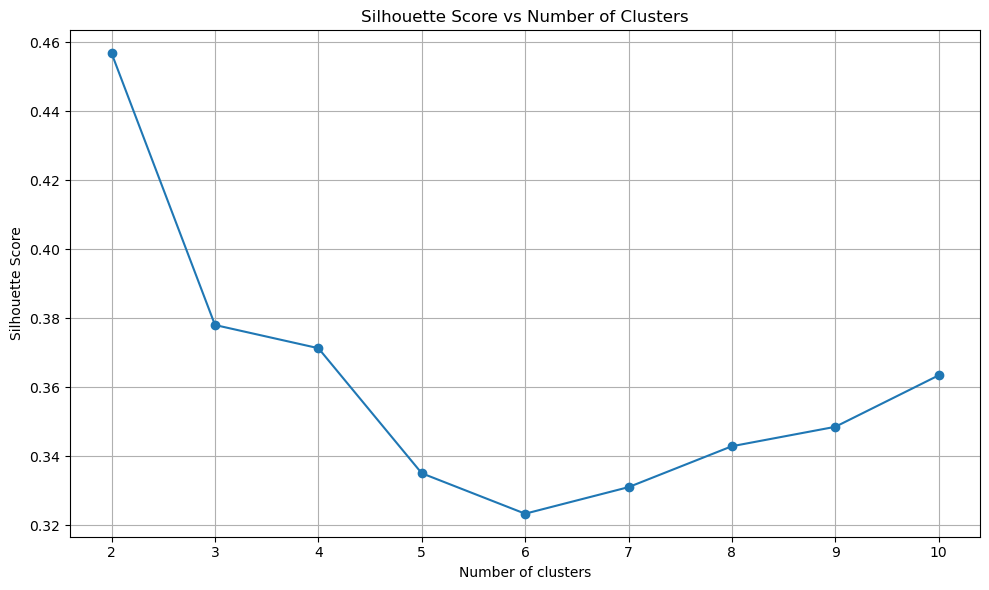

In [ ]:
silhouette_scores = []

for k in range(2, 11):
    agg_clustering = AgglomerativeClustering(n_clusters=k, linkage='ward')
    cluster_labels = agg_clustering.fit_predict(umap_df)
    silhouette_avg = silhouette_score(umap_df, cluster_labels)
    silhouette_scores.append(silhouette_avg)

plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs Number of Clusters')
plt.grid(True)
plt.tight_layout()

plt.show()

Average Silhouette Score for k=2: 0.4568


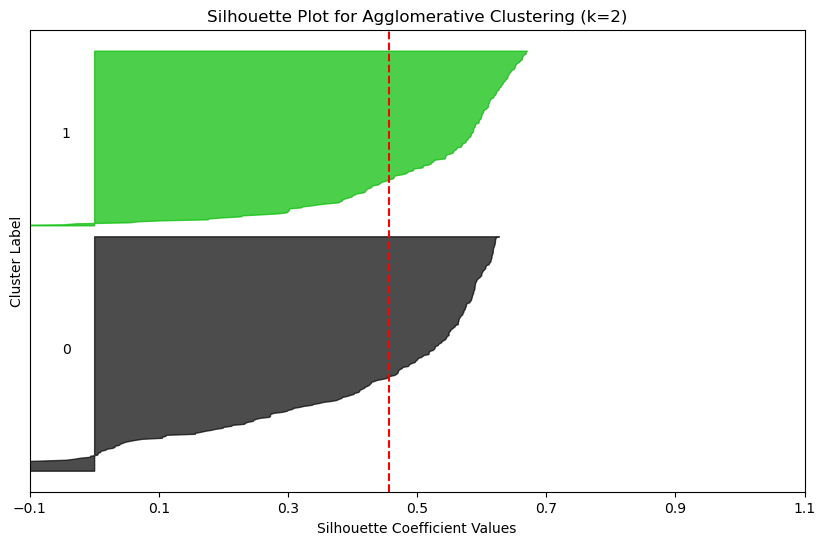

In [ ]:
k = 2

# Initialize Agglomerative Clustering
agg_clustering = AgglomerativeClustering(n_clusters=k, linkage='ward')

# Fit the model and predict cluster labels
cluster_labels = agg_clustering.fit_predict(umap_df)

# Add cluster labels to the DataFrame (optional)
umap_df['Cluster'] = cluster_labels

# Compute the average Silhouette Score
silhouette_avg = silhouette_score(umap_df.drop('Cluster', axis=1), cluster_labels)
print(f"Average Silhouette Score for k={k}: {silhouette_avg:.4f}")

# Compute the Silhouette Score for each sample
sample_silhouette_values = silhouette_samples(umap_df.drop('Cluster', axis=1), cluster_labels)

# Initialize the matplotlib figure
plt.figure(figsize=(10, 6))

# Create a subplot for the Silhouette Plot
ax1 = plt.subplot(1, 1, 1)

# The silhouette coefficient can range from -1, 1 but in general, positive values indicate correct clustering
ax1.set_xlim([-0.1, 1])

# Initialize the y_lower for the first cluster
y_lower = 10

# Get the unique cluster labels
unique_clusters = np.unique(cluster_labels)

# Number of samples
n_samples = len(cluster_labels)

for i in unique_clusters:
    # Aggregate the silhouette scores for samples belonging to cluster i
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
    
    # Sort the Silhouette Scores for cluster i
    ith_cluster_silhouette_values.sort()
    
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    
    # Choose a color for the cluster
    color = cm.nipy_spectral(float(i) / k)
    
    # Fill the silhouette scores for cluster i
    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)
    
    # Label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    
    # Update the y_lower for the next plot
    y_lower = y_upper + 10  # 10 for the 10-point vertical space between clusters

# Draw a vertical line for the average Silhouette Score of all the values
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

# Set labels and titles
ax1.set_title(f"Silhouette Plot for Agglomerative Clustering (k={k})")
ax1.set_xlabel("Silhouette Coefficient Values")
ax1.set_ylabel("Cluster Label")

# Remove the y-axis labels and ticks
ax1.set_yticks([])
ax1.set_xticks(np.arange(-0.1, 1.1, 0.2))

plt.show()

Here is that clustering result printed back on the UMAP plot

<Axes: xlabel='UMAP1', ylabel='UMAP2'>

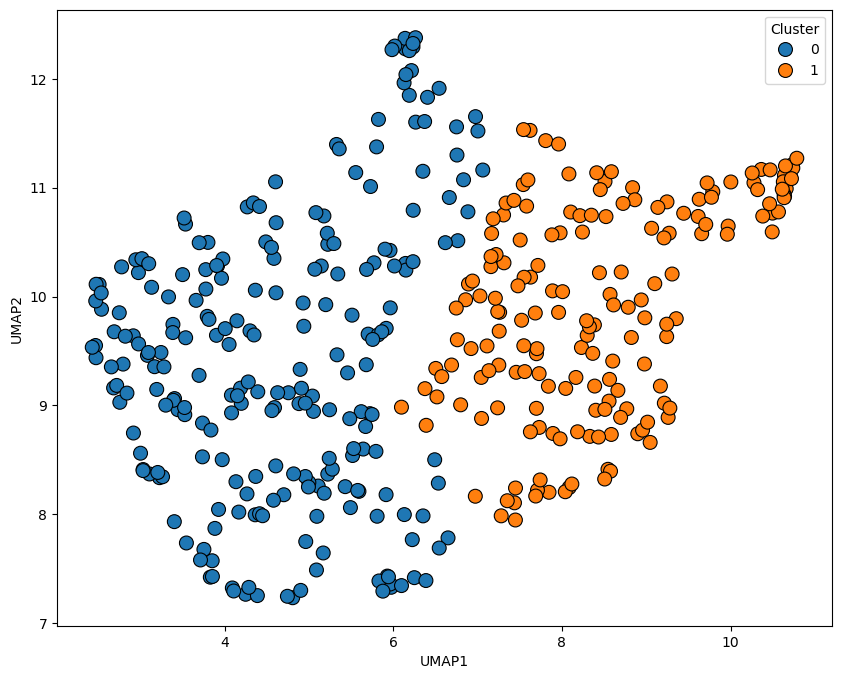

In [ ]:
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='UMAP1',
    y='UMAP2',
    data=umap_df,
    s=100,
    color='blue',
    edgecolor='k',
    hue='Cluster'
)

In [ ]:
umap_df['Cluster'].to_csv('Results/TCGA_clustering_results.csv')

Here is the Kaplan Meier result from this clustering data

In [ ]:
TCGA_surv = TCGA_surv.T

TCGA_surv['Cluster'] = umap_df['Cluster'].T
surv_clust = TCGA_surv
surv_clust.dropna(axis=1, inplace=True)
print(surv_clust.head())

                              vital  days_survival  Cluster
barcode                                                    
TCGA-HQ-A5ND-01A-11R-A26T-07    1.0          274.0        1
TCGA-G2-A3IB-01A-11R-A20F-07    1.0          220.0        0
TCGA-ZF-AA5N-01A-11R-A42T-07    1.0          168.0        1
TCGA-FD-A6TF-01A-52R-A32O-07    1.0           69.0        1
TCGA-GC-A3WC-01A-31R-A22U-07    0.0          540.0        0



Log-Rank Test Results:
   Cluster 1  Cluster 2       p-value
0          0          1  5.610603e-10


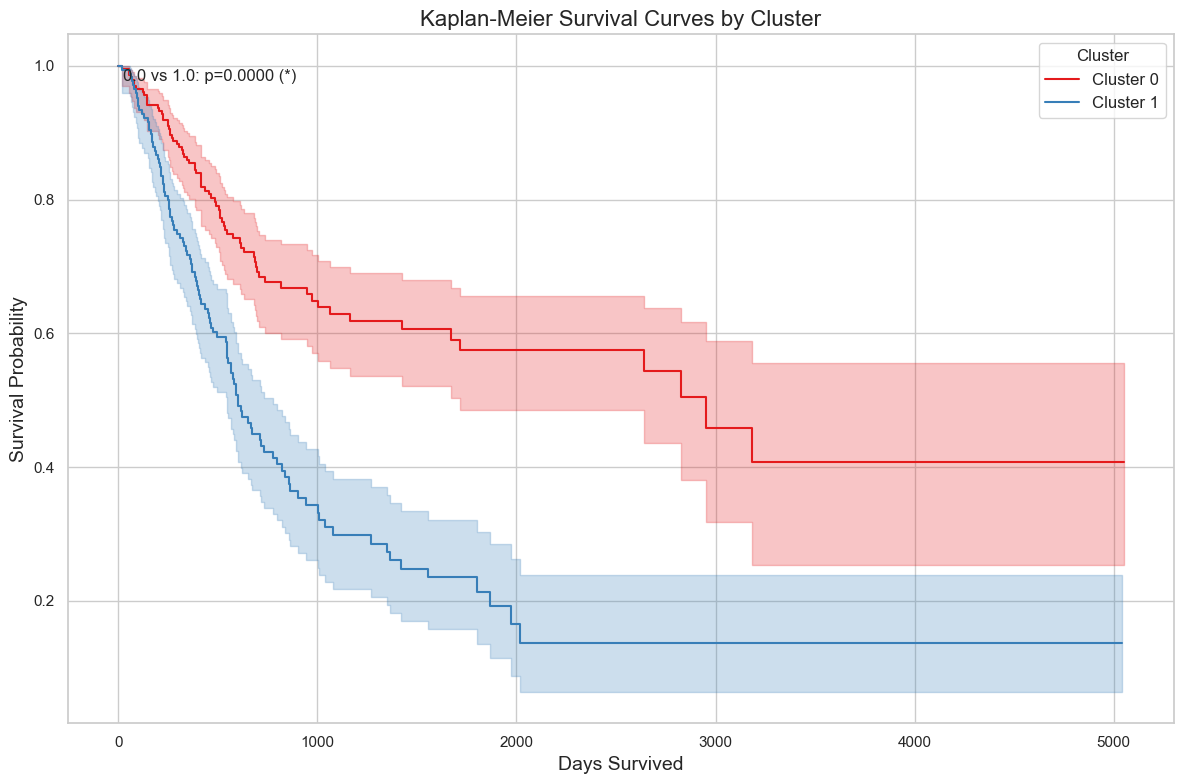

In [ ]:
sns.set(style="whitegrid")

kmf = KaplanMeierFitter()
clusters = sorted(surv_clust['Cluster'].unique())
palette = sns.color_palette("Set1", n_colors=len(clusters))

# Log-rank test
logrank_results = []
for (cluster1, cluster2) in combinations(clusters, 2):
    data1 = surv_clust[surv_clust['Cluster'] == cluster1]
    data2 = surv_clust[surv_clust['Cluster'] == cluster2]
    
    result = logrank_test(
        data1['days_survival'], data2['days_survival'],
        event_observed_A=data1['vital'], event_observed_B=data2['vital']
    )
    
    logrank_results.append({
        'Cluster 1': cluster1,
        'Cluster 2': cluster2,
        'p-value': result.p_value
    })

logrank_df = pd.DataFrame(logrank_results)

# Print the results
print("\nLog-Rank Test Results:")
print(logrank_df)

# Plot Kaplan-Meier curves with annotations
plt.figure(figsize=(12, 8))

for cluster, color in zip(clusters, palette):
    cluster_data = surv_clust[surv_clust['Cluster'] == cluster]
    kmf.fit(
        durations=cluster_data['days_survival'],
        event_observed=cluster_data['vital'],
        label=f'Cluster {cluster}'
    )
    kmf.plot_survival_function(ax=plt.gca(), color=color)

plt.title('Kaplan-Meier Survival Curves by Cluster', fontsize=16)
plt.xlabel('Days Survived', fontsize=14)
plt.ylabel('Survival Probability', fontsize=14)
plt.legend(title='Cluster', fontsize=12, title_fontsize=12)
plt.grid(True)

for index, row in logrank_df.iterrows():
    cluster1 = row['Cluster 1']
    cluster2 = row['Cluster 2']
    p_val = row['p-value']
    significance = '*' if p_val < 0.05 else 'ns'
    annotation_text = f'{cluster1} vs {cluster2}: p={p_val:.4f} ({significance})'
    
    plt.text(
        0.05,
        0.95 - index * 0.05,
        annotation_text,
        transform=plt.gca().transAxes,
        fontsize=12,
        verticalalignment='top'
    )

plt.tight_layout()
plt.show()


### BCTE Classifier Development

To assess whether molecular clusters identified via unsupervised learning could be predicted from the underlying transcriptomic features, we developed a supervised classification model using a **Random Forest classifier**.

The process involved the following steps:

**1. Data Preparation**  
We combined the cluster labels with the scaled expression features and removed missing values. The dataset was then split into training (80%) and testing (20%) sets using stratified sampling to preserve cluster proportions.

**2. Pipeline Construction**  
A **scikit-learn pipeline** was built to streamline preprocessing and modeling. The pipeline included:
- **StandardScaler** for normalization
- **PCA** for dimensionality reduction, retaining 95% of variance
- **RandomForestClassifier** as the learning algorithm

**3. Model Optimization via Grid Search**  
We performed **grid search with 5-fold cross-validation** to optimize hyperparameters, including:
- Number of estimators (`n_estimators`)
- Tree depth (`max_depth`)
- Minimum samples required for split and leaf nodes

The best-performing model was selected based on cross-validated **accuracy**.

**4. Model Evaluation**  
The optimized model was evaluated on the held-out test set using:
- **Accuracy score**
- **Classification report** (precision, recall, F1-score)
- **Confusion matrix** (visualized as a heatmap)

These metrics confirmed the model’s ability to predict cluster identity from molecular features.

**5. Model Export and Reuse**  
The final model was saved using `joblib` for reproducibility and later use in downstream analyses.

In [ ]:
all = pd.concat([umap_df['Cluster'], clustering_data_scaled], axis=1)
all.dropna(inplace=True)
X = all.drop('Cluster', axis=1)
y = all['Cluster']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f'Training samples: {X_train.shape[0]}')
print(f'Testing samples: {X_test.shape[0]}')

Training samples: 329
Testing samples: 83


In [ ]:
pipeline = Pipeline([
    ('scaling', StandardScaler()),
    ('pca', PCA(n_components=0.95, random_state=42)),
    ('classifier', RandomForestClassifier(random_state=42))
])

In [ ]:
param_grid = {
    'classifier__n_estimators': [50, 100, 150, 200],
    'classifier__max_depth': [None, 5, 10, 15, 20],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 5]
}

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,  
    n_jobs=-1,
    scoring='accuracy',
    verbose=2
)

grid_search.fit(X_train, y_train)

print("Best Parameters:\n", grid_search.best_params_)

Fitting 5 folds for each of 180 candidates, totalling 900 fits
[CV] END classifier__max_depth=None, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=50; total time=   0.3s
[CV] END classifier__max_depth=None, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=50; total time=   0.3s
[CV] END classifier__max_depth=None, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=50; total time=   0.3s
[CV] END classifier__max_depth=None, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=50; total time=   0.3s
[CV] END classifier__max_depth=None, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=50; total time=   0.4s
[CV] END classifier__max_depth=None, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=100; total time=   0.6s
[CV] END classifier__max_depth=None,

#### Hold-out set Validation

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.98      0.96        48
           1       0.97      0.91      0.94        35

    accuracy                           0.95        83
   macro avg       0.95      0.95      0.95        83
weighted avg       0.95      0.95      0.95        83



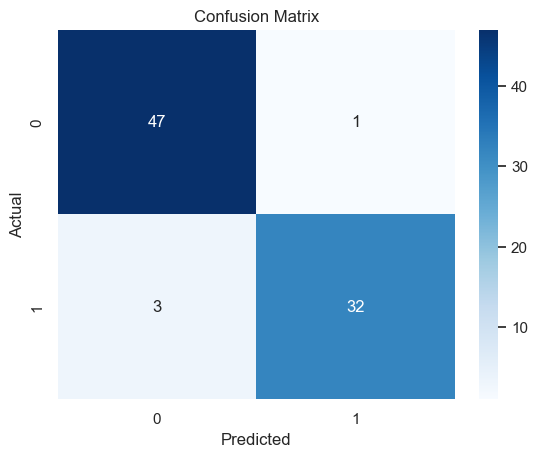

Accuracy: 0.95


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

y_pred = grid_search.predict(X_test)

print("Classification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

#### Saving Model

In [ ]:
joblib.dump(grid_search.best_estimator_, 'rna_seq_classifier.joblib')

### External Validation

#### UROMOL (NMIBC Cohort)

The UROMOL cohort is a European multicenter study comprising 834 patients diagnosed with non-muscle-invasive bladder cancer (NMIBC). This comprehensive analysis aimed to elucidate the molecular heterogeneity of NMIBC and its clinical implications. Through transcriptomic profiling, researchers identified four distinct molecular classes: 1, 2a, 2b, and 3, each correlating with varying tumor biology and disease aggressiveness. Notably, Class 2a tumors exhibited high chromosomal instability and a disrupted p53 pathway, indicating a poorer prognosis. In contrast, Class 2b tumors showed significant immune cell infiltration, suggesting potential responsiveness to immunotherapeutic strategies. Importantly, these transcriptomic classifications offer prognostic value beyond traditional clinicopathological parameters, providing a refined framework for risk stratification and personalized treatment approaches in NMIBC management.

[An integrated multi-omics analysis identifies prognostic molecular subtypes of non-muscle-invasive bladder cancer](https://www.sciencedirect.com/science/article/pii/S0092867417310565)

In [ ]:
UROMOL_TE = pd.read_csv('InputData/UROMOL/Clean-UROMOL-TE.csv', index_col=0)
UROMOL_clinical = pd.read_csv('InputData/UROMOL/uromol_corelation_analysis_dataset.csv', index_col=0)
UROMOL_surv = UROMOL_clinical.loc[:, ['time_pfs', 'event_pfs', 'time_rfs', 'event_rfs']]

In [ ]:
UROMOL_TE_for_model = UROMOL_TE.loc[lasso_sig_TE, :]
UROMOL_TE_scaled = pd.DataFrame(scaler.fit_transform(UROMOL_TE_for_model.T),
                              index=UROMOL_TE_for_model.columns,
                              columns=UROMOL_TE_for_model.index)

In [ ]:
best_model = joblib.load('Results/rna_seq_classifier.joblib')

In [ ]:
new_predictions = best_model.predict(UROMOL_TE_scaled)
new_probabilities = best_model.predict_proba(UROMOL_TE_scaled)

In [ ]:
cluster_df = pd.DataFrame(new_predictions, index=UROMOL_TE_scaled.index, columns=['Cluster_pred'])

In [ ]:
cluster_df['Cluster_pred'].to_csv('Results/UROMOL_clustering_results.csv')

In [ ]:
surv_df = UROMOL_surv.copy()
clust_df = pd.read_csv('Results/UROMOL_clustering_results.csv', index_col=0)

#surv_df.index = surv_df.index.astype(str).str.strip().str.upper()
#clust_df.index = clust_df.index.astype(str).str.strip().str.upper()

# Now concat (aligning on index)
UROMOL_surv_cluster = pd.concat([surv_df, clust_df], axis=1)
UROMOL_surv_cluster.dropna(inplace=True)

In [ ]:
print(UROMOL_surv_cluster)

       time_pfs  event_pfs  time_rfs  event_rfs  Cluster_pred
U2062  3.572500        0.0  1.000000        1.0           1.0
U0048  4.333333        0.0  4.333333        0.0           0.0
U2049  0.466667        1.0  0.466667        1.0           0.0
U0200  5.000000        0.0  0.358333        1.0           1.0
U0125  1.655833        0.0  1.655833        0.0           0.0
...         ...        ...       ...        ...           ...
U0903  1.297500        0.0  1.297500        0.0           0.0
U1182  5.000000        0.0  1.225000        1.0           0.0
U0122  5.000000        0.0  5.000000        0.0           0.0
U0666  5.000000        0.0  0.550000        1.0           0.0
U2114  4.144167        0.0  0.450000        1.0           0.0

[497 rows x 5 columns]


Log-rank test results:
Cluster 0 vs Cluster 1: p-value = 0.00036895653684662915


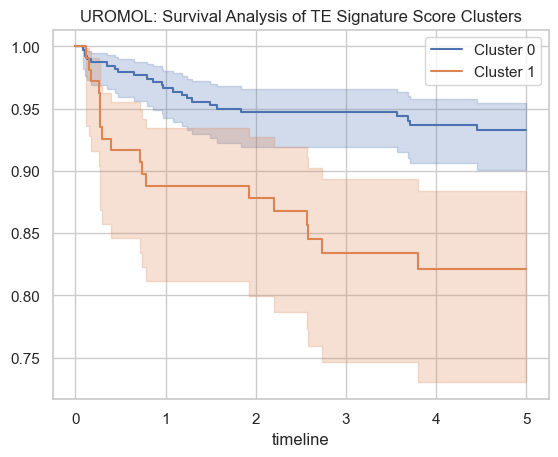

In [ ]:
cluster1_index = UROMOL_surv_cluster[UROMOL_surv_cluster['Cluster_pred'] == 0].index
cluster2_index = UROMOL_surv_cluster[UROMOL_surv_cluster['Cluster_pred'] == 1].index

cluster1_survival_data = UROMOL_surv_cluster.loc[cluster1_index, ['time_pfs', 'event_pfs']]
cluster2_survival_data = UROMOL_surv_cluster.loc[cluster2_index, ['time_pfs', 'event_pfs']]

from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt
from lifelines.statistics import logrank_test

ax = plt.subplot(111)
kmf = KaplanMeierFitter()

# Cluster 0 Survival Plot
T_1 = cluster1_survival_data["time_pfs"]
E_1 = cluster1_survival_data["event_pfs"]
kmf.fit(T_1, event_observed=E_1, label="Cluster 0")
kmf.plot_survival_function(ax=ax)

# Cluster 1 Survival Plot
T_2 = cluster2_survival_data["time_pfs"]
E_2 = cluster2_survival_data["event_pfs"]
kmf.fit(T_2, event_observed=E_2, label="Cluster 1")
kmf.plot_survival_function(ax=ax)

plt.title("UROMOL: Survival Analysis of TE Signature Score Clusters")

# Perform the log-rank test
results_1_vs_2 = logrank_test(T_1, T_2, event_observed_A=E_1, event_observed_B=E_2)

# Print the p-value of the log-rank test
print("Log-rank test results:")
print("Cluster 0 vs Cluster 1: p-value =", results_1_vs_2.p_value)

plt.show()

Though tested, the recurrence free survival (rfs) was compared between TE defined subtypes though remained statistically insignificant. 

Log-rank test results:
Cluster 0 vs Cluster 1: p-value = 0.2831479908061336


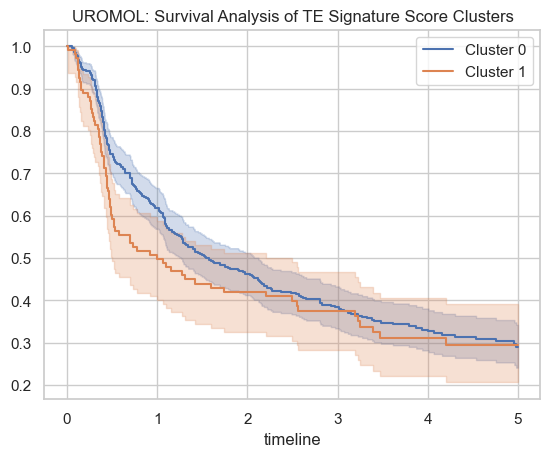

In [ ]:
cluster1_index = UROMOL_surv_cluster[UROMOL_surv_cluster['Cluster_pred'] == 0].index
cluster2_index = UROMOL_surv_cluster[UROMOL_surv_cluster['Cluster_pred'] == 1].index

cluster1_survival_data = UROMOL_surv_cluster.loc[cluster1_index, ['time_rfs', 'event_rfs']]
cluster2_survival_data = UROMOL_surv_cluster.loc[cluster2_index, ['time_rfs', 'event_rfs']]

from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt
from lifelines.statistics import logrank_test

ax = plt.subplot(111)
kmf = KaplanMeierFitter()

# Cluster 0 Survival Plot
T_1 = cluster1_survival_data["time_rfs"]
E_1 = cluster1_survival_data["event_rfs"]
kmf.fit(T_1, event_observed=E_1, label="Cluster 0")
kmf.plot_survival_function(ax=ax)

# Cluster 1 Survival Plot
T_2 = cluster2_survival_data["time_rfs"]
E_2 = cluster2_survival_data["event_rfs"]
kmf.fit(T_2, event_observed=E_2, label="Cluster 1")
kmf.plot_survival_function(ax=ax)

plt.title("UROMOL: Survival Analysis of TE Signature Score Clusters")

# Perform the log-rank test
results_1_vs_2 = logrank_test(T_1, T_2, event_observed_A=E_1, event_observed_B=E_2)

# Print the p-value of the log-rank test
print("Log-rank test results:")
print("Cluster 0 vs Cluster 1: p-value =", results_1_vs_2.p_value)

plt.show()

#### PURE01 (Pembrolizumab Treated MIBC - pre-treatment)

The PURE-01 trial is a phase II, single-arm, open-label study evaluating the efficacy of neoadjuvant pembrolizumab in patients with muscle-invasive bladder cancer (MIBC) prior to radical cystectomy. Initially enrolling patients with predominant urothelial carcinoma histology and clinical stage cT≤3bN0M0, the study was later amended to include those with variant histologies (VH), such as squamous-cell carcinoma (SCC) and lymphoepithelioma-like (LEL) variants .

Participants received three cycles of pembrolizumab (200 mg every 3 weeks) before surgery. The primary endpoint was the rate of pathological complete response (pT0) in the intention-to-treat population. Among the 114 patients enrolled between February 2017 and June 2019, the overall pT0 rate was 37%, with a pT≤1 rate of 55%. Notably, patients with SCC and LEL features demonstrated higher response rates, with 86% of SCC patients achieving downstaging to pT≤1 .

Biomarker analyses revealed that higher tumor mutational burden (TMB) and PD-L1 expression (measured by combined positive score, CPS) were associated with better pathological responses, regardless of histological subtype. These findings suggest that TMB and CPS may serve as predictive biomarkers for response to neoadjuvant pembrolizumab in MIBC .

[Updated Results of PURE-01 with Preliminary Activity of Neoadjuvant Pembrolizumab in Patients with Muscle-invasive Bladder Carcinoma with Variant Histologies](https://www.sciencedirect.com/science/article/abs/pii/S0302283819308255)

In [ ]:
PURE_TE = pd.read_csv('InputData/PURE01/pure01_TE.csv', index_col=0)
PURE_TE.columns = PURE_TE.columns.str.split('_').str[0].unique()

PURE_TE_for_model = PURE_TE.loc[lasso_sig_TE, :]

scaler = StandardScaler()

PURE_TE_scaled = pd.DataFrame(scaler.fit_transform(PURE_TE_for_model.T),
                              index=PURE_TE_for_model.columns,
                              columns=PURE_TE_for_model.index)
PURE_clinical = pd.read_csv('InputData/PURE01/PURE01_Metadata.csv', index_col='Fastq.file.ID')

In [ ]:
new_predictions = best_model.predict(PURE_TE_scaled)
new_probabilities = best_model.predict_proba(PURE_TE_scaled)

In [ ]:
cluster_df = pd.DataFrame(new_predictions, index=PURE_TE_scaled.index, columns=['Cluster_pred'])

In [ ]:
cluster_df['Cluster_pred'].to_csv('Results/PURE01_clustering_results.csv')

In [ ]:
cluster_df = pd.read_csv('Results/PURE01_clustering_results.csv', index_col=0)

In [ ]:
PURE_clinical['Cluster_pred'] = cluster_df

Log-rank test results:
Cluster 0 vs Cluster 1: p-value = 0.042073959303971835


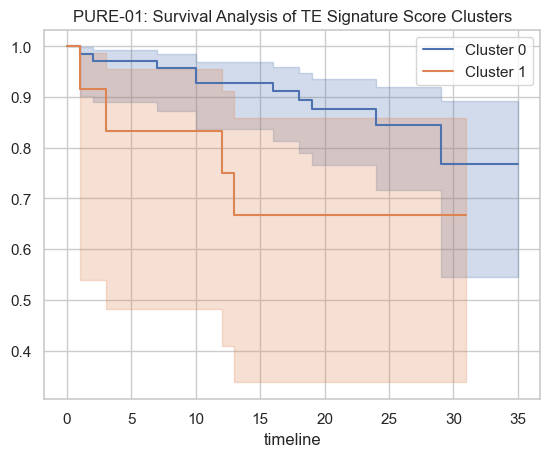

In [ ]:
cluster1_index = PURE_clinical[PURE_clinical['Cluster_pred'] == 0].index
cluster2_index = PURE_clinical[PURE_clinical['Cluster_pred'] == 1].index

cluster1_survival_data = PURE_clinical.loc[cluster1_index, ['Time.to.recurrence', 'RELAPSE']]
cluster2_survival_data = PURE_clinical.loc[cluster2_index, ['Time.to.recurrence', 'RELAPSE']]

from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt
from lifelines.statistics import logrank_test

ax = plt.subplot(111)
kmf = KaplanMeierFitter()

T_1 = cluster1_survival_data["Time.to.recurrence"]
E_1 = cluster1_survival_data["RELAPSE"]
kmf.fit(T_1, event_observed=E_1, label="Cluster 0")
kmf.plot_survival_function(ax=ax)

T_2 = cluster2_survival_data["Time.to.recurrence"]
E_2 = cluster2_survival_data["RELAPSE"]
kmf.fit(T_2, event_observed=E_2, label="Cluster 1")
kmf.plot_survival_function(ax=ax)

plt.title("PURE-01: Survival Analysis of TE Signature Score Clusters")

results_1_vs_2 = logrank_test(T_1, T_2, event_observed_A=E_1, event_observed_B=E_2)

print("Log-rank test results:")
print("Cluster 0 vs Cluster 1: p-value =", results_1_vs_2.p_value)

plt.show()

## De Carvalho Hypothesis

1. all LINE, SINE, LTR sequences can generate dsRNA
2. expression promotes MDA5 + RIG-I detection
3. ADAR1p150 inhibits the development of dsRNA and therefore the effect of above TEs 

'Viral mimicry augments the adaptive immune response. Aberrantly transcribed LTR ORFs are translated in the cytoplasm and processed by the proteasome into ERV peptides that act as TAAs. Overall T-cell activation induced by TAA recognition is further enhanced by the viral mimicry–mediated upregulation of ISGs such as antigen processing components (e.g., the proteasome subunits LMP2/7/10 or the peptide transporter TAP) and antigen presentation components (e.g., MHC-I, β2m). Additionally, chemokines that promote T-cell infiltration (e.g., CCL5, CXCL9, and CXCL10) are also ISGs that are activated by viral mimicry. The upregulation of antigen processing and presentation components, increased expression of retrotransposon-derived TAAs, and increased T-cell infiltration enhances overall tumor immunogenicity and improves the efficacy of ICB therapies'

In [ ]:
rmsk = pd.read_csv('InputData/ReferenceData/rmsk_annotation.csv', index_col='repName')
print(rmsk['repClass'].value_counts())

repClass
SINE                                         1762309
LINE                                         1503078
LTR                                           712367
Simple_repeat                                 504713
DNA                                           479805
                                              ...   
SINE,DNA,LINE                                      1
LINE,LTR                                           1
Simple_repeat,LTR,LINE,DNA,SINE                    1
LINE,SINE,Simple_repeat                            1
Simple_repeat,LINE,Low_complexity,DNA,LTR          1
Name: count, Length: 105, dtype: int64


In [ ]:
ADAR1 = TumourGene.loc['ADAR', :]

MDA5 = TumourGene.loc['IFIH1', :]
RIGI = TumourGene.loc['DDX58', :]

LMP2 = TumourGene.loc['PSMB9', :]
LMP7 = TumourGene.loc['PSMB8', :]
LMP10 = TumourGene.loc['PSMB10', :]

TAP1 = TumourGene.loc['TAP1', :]

MHCIa = TumourGene.loc['HLA-A', :]
MHCIb = TumourGene.loc['HLA-B', :]
MHCIc = TumourGene.loc['HLA-C', :]
B2M = TumourGene.loc['B2M', :]

CCL5 = TumourGene.loc['CCL5', :]
CXCL9 = TumourGene.loc['CXCL9', :]
CXCL10 = TumourGene.loc['CXCL10', :]

In [ ]:
dsRNA_TEs = rmsk[rmsk['repClass'].isin(['LINE', 'SINE', 'LTR'])].index.unique().values.tolist()

dsRNA_TEs_clean = []

for item in dsRNA_TEs:
    if ',' in item: 
        item = item.split(',')[0]
    dsRNA_TEs_clean.append(item)

viral_mimicry_TEs = TE.loc[dsRNA_TEs_clean, :].mean()

In [ ]:
dsRNA_TEs = rmsk[rmsk['repClass'].isin(['LINE'])].index.unique().values.tolist()

dsRNA_TEs_clean = []

for item in dsRNA_TEs:
    if ',' in item: 
        item = item.split(',')[0]
    dsRNA_TEs_clean.append(item)

line = TE.loc[dsRNA_TEs_clean, :].mean()

In [ ]:
dsRNA_TEs = rmsk[rmsk['repClass'].isin(['SINE'])].index.unique().values.tolist()

dsRNA_TEs_clean = []

for item in dsRNA_TEs:
    if ',' in item: 
        item = item.split(',')[0]
    dsRNA_TEs_clean.append(item)

sine = TE.loc[dsRNA_TEs_clean, :].mean()

In [ ]:
dsRNA_TEs = rmsk[rmsk['repClass'].isin(['LTR'])].index.unique().values.tolist()

dsRNA_TEs_clean = []

for item in dsRNA_TEs:
    if ',' in item: 
        item = item.split(',')[0]
    dsRNA_TEs_clean.append(item)

ltr = TE.loc[dsRNA_TEs_clean, :].mean()

In [ ]:
MHCI_path = ['IFIH1', 'DDX58', 'PSMB9', 'PSMB8', 'PSMB10', 'TAP1', 'HLA-A','HLA-B', 'HLA-C', 'B2M', 'CCL5', 'CXCL9', 'CXCL10']
tmp_features = Gene.loc[MHCI_path, :].T
tmp_features['Viral Mimicry TEs (LINE, SINE, LTR)'] = viral_mimicry_TEs
tmp_features['LINE'] = line
tmp_features['SINE'] = sine
tmp_features['LTR'] = ltr
viral_mim = tmp_features.T
viral_mim.dropna(inplace=True, axis=1)

features = viral_mim.index

All selected genes are present in the dataframe.


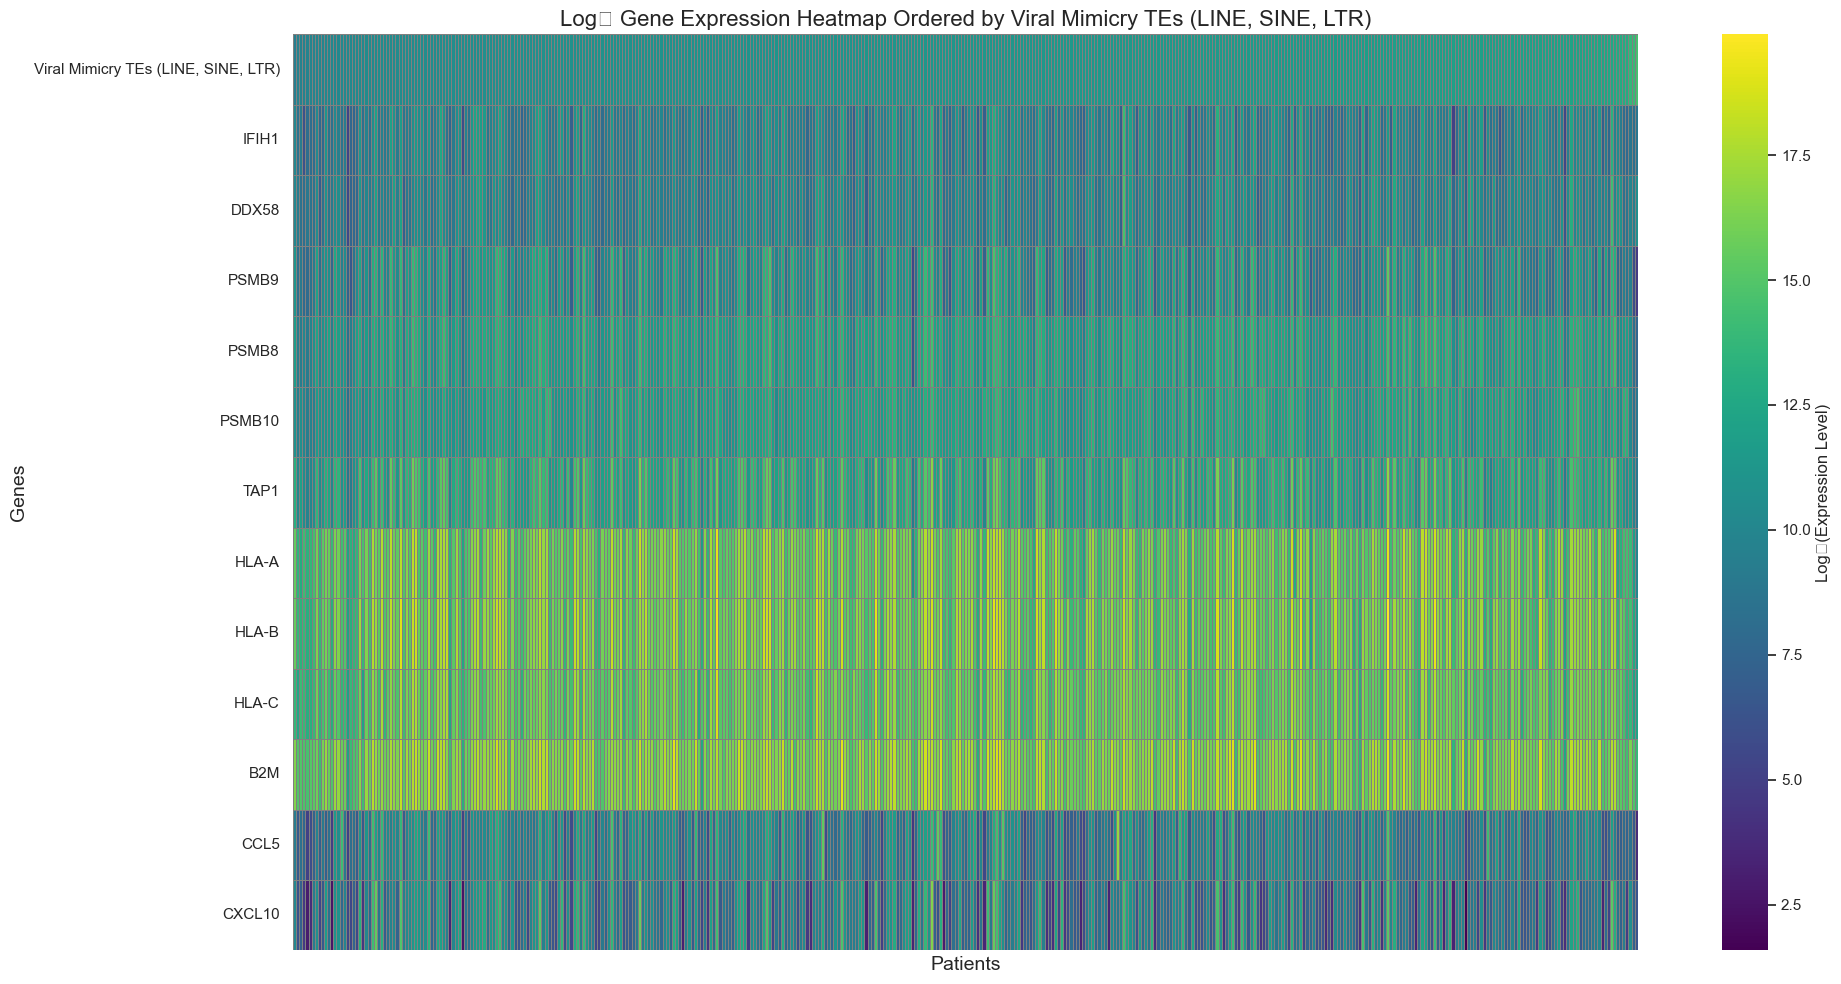

In [ ]:
bare_viral_mim = viral_mim.drop(['LINE', 'SINE', 'LTR'], axis=0)

# ============================================
# Step 2: Define the Selected Genes
# ============================================

selected_genes = [
    'Viral Mimicry TEs (LINE, SINE, LTR)',
    'IFIH1',
    'DDX58',
    'PSMB9',
    'PSMB8',
    'PSMB10',
    'TAP1',
    'HLA-A',
    'HLA-B',
    'HLA-C',
    'B2M',
    'CCL5',
    'CXCL10'
]

# ============================================
# Step 3: Verify the Presence of Selected Genes
# ============================================

present_genes = [gene for gene in selected_genes if gene in bare_viral_mim.index]
missing_genes = [gene for gene in selected_genes if gene not in bare_viral_mim.index]

if missing_genes:
    print("The following selected genes are missing from the dataframe:")
    for gene in missing_genes:
        print(f"- {gene}")
    # Proceeding with available genes
else:
    print("All selected genes are present in the dataframe.")

# ============================================
# Step 4: Subset the DataFrame
# ============================================

sorted_genes = present_genes  # Ordered list of genes to include
sorted_df = bare_viral_mim.loc[sorted_genes]

# ============================================
# Step 5: Log2 Transformation
# ============================================

# Check for non-positive values
if (sorted_df <= 0).any().any():
    print("Data contains non-positive values. Adding a pseudocount of 1 to avoid issues with log2.")
    sorted_df = sorted_df + 1  # Adding pseudocount

# Apply log2 transformation
sorted_df_log2 = np.log2(sorted_df)

# ============================================
# Step 6: Sort Patients Based on Viral Mimicry Expression
# ============================================

# Ensure the specific row exists
if 'Viral Mimicry TEs (LINE, SINE, LTR)' not in sorted_df_log2.index:
    raise ValueError("The row 'Viral Mimicry TEs (LINE, SINE, LTR)' does not exist in the dataframe.")

# Extract the specific row for ordering
viral_mim_row = sorted_df_log2.loc['Viral Mimicry TEs (LINE, SINE, LTR)']

# Sort patients based on the expression levels in the viral mimicry row
sorted_patients = viral_mim_row.sort_values(ascending=True).index

# Reorder the dataframe columns (patients) based on the sorted order
sorted_df_log2 = sorted_df_log2[sorted_patients]

# ============================================
# Step 7: Create the Heatmap
# ============================================

# Set the size of the heatmap
plt.figure(figsize=(20, 10))  # Adjust the size as necessary

# Create the heatmap
sns.heatmap(
    sorted_df_log2,
    cmap='viridis',             # Choose an appropriate color map
    linewidths=0.5,             # Lines between cells
    linecolor='gray',
    xticklabels=False,          # **Set to False to remove x-axis labels**
    yticklabels=True,           # Keep y-axis labels (gene names)
    cbar_kws={'label': 'Log₂(Expression Level)'}
)

# Add title and labels
plt.title('Log₂ Gene Expression Heatmap Ordered by Viral Mimicry TEs (LINE, SINE, LTR)', fontsize=16)
plt.xlabel('Patients', fontsize=14)    # Label remains, but no ticks
plt.ylabel('Genes', fontsize=14)

# Rotate x-axis labels if necessary (optional since labels are removed)
# plt.xticks(rotation=90)  # No effect since xticklabels=False

# Optimize layout to prevent clipping
plt.tight_layout()

# Optional: Save the heatmap
# plt.savefig('log2_gene_expression_heatmap_selected_genes.png', dpi=300, bbox_inches='tight')

# Display the heatmap
plt.show()

In [ ]:
TE = viral_mim.loc['Viral Mimicry TEs (LINE, SINE, LTR)',:]

for item in viral_mim.index:
    comparitor = viral_mim.loc[item, :]
    pearson = scipy.stats.pearsonr(TE, comparitor)

    print(item, pearson)

IFIH1 PearsonRResult(statistic=-0.030956842129714512, pvalue=0.5205732143711901)
DDX58 PearsonRResult(statistic=0.04511507991220196, pvalue=0.3489915186585049)
PSMB9 PearsonRResult(statistic=-0.07674456502030351, pvalue=0.11078219105758491)
PSMB8 PearsonRResult(statistic=-0.027664754647385246, pvalue=0.5658919589681851)
PSMB10 PearsonRResult(statistic=0.021137484694161903, pvalue=0.6609368088723895)
TAP1 PearsonRResult(statistic=-0.0693187253595867, pvalue=0.14986959903402686)
HLA-A PearsonRResult(statistic=-0.05184504764725477, pvalue=0.28173451583520714)
HLA-B PearsonRResult(statistic=-0.06866797479356983, pvalue=0.15374088286913942)
HLA-C PearsonRResult(statistic=-0.07101613146990113, pvalue=0.14012074982343986)
B2M PearsonRResult(statistic=-0.05437672457165805, pvalue=0.2588678754662164)
CCL5 PearsonRResult(statistic=-0.04647589506947386, pvalue=0.33463167556680323)
CXCL9 PearsonRResult(statistic=-0.05483548259678299, pvalue=0.25486547611059596)
CXCL10 PearsonRResult(statistic=-0.0

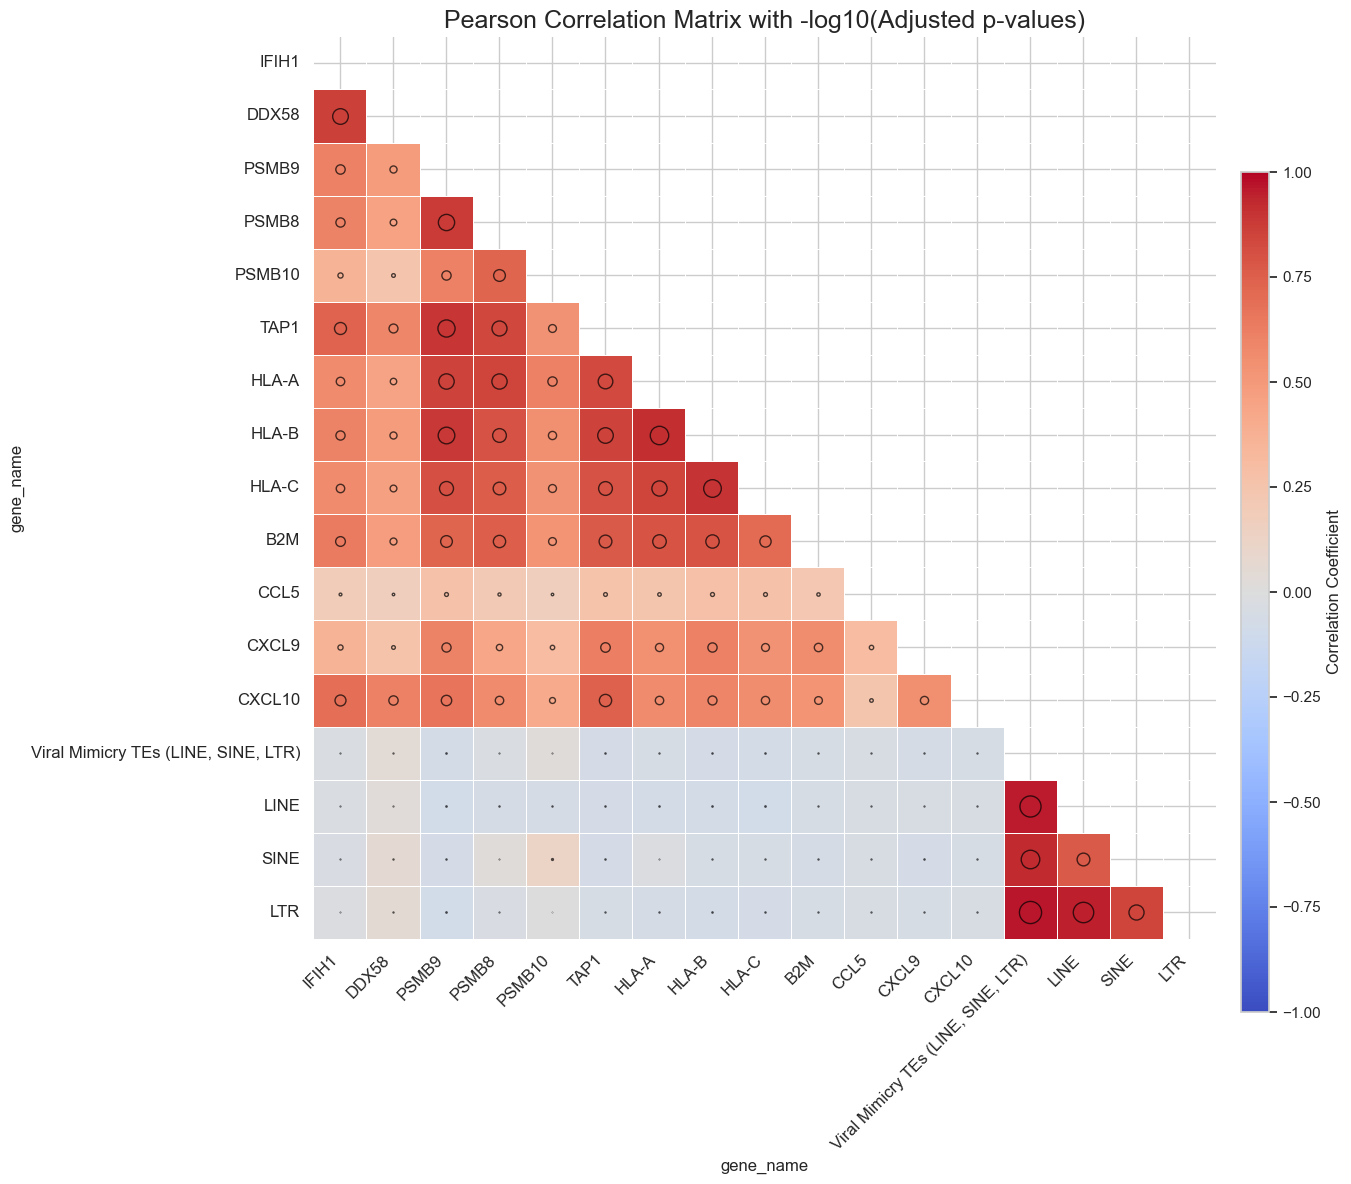

In [ ]:
import pandas as pd
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.multitest import multipletests
from matplotlib.lines import Line2D

# Assuming 'features' is already defined and 'viral_mim' is your dataframe

# Step 1: Initialize correlation and p-value matrices
corr_matrix = pd.DataFrame(index=features, columns=features, dtype=float)
pval_matrix = pd.DataFrame(index=features, columns=features, dtype=float)

# Step 2: Compute Pearson correlation and p-values
for feat1 in features:
    for feat2 in features:
        # Compute Pearson correlation and p-value
        corr, pval = scipy.stats.pearsonr(
            viral_mim.loc[feat1, :].values.tolist(),
            viral_mim.loc[feat2, :].values.tolist()
        )
        corr_matrix.loc[feat1, feat2] = corr
        pval_matrix.loc[feat1, feat2] = pval

# Step 3: Adjust p-values for multiple testing using Benjamini-Hochberg
# Flatten the p-value matrix for adjustment
pvals = pval_matrix.values.flatten()
# Apply Benjamini-Hochberg correction
reject, pvals_corrected, _, _ = multipletests(pvals, method='fdr_bh')
# Reshape the corrected p-values back to matrix form
pval_matrix_corrected = pd.DataFrame(
    pvals_corrected.reshape(pval_matrix.shape),
    index=pval_matrix.index,
    columns=pval_matrix.columns
)

# Step 4: Compute -log10(adjusted p-values)
# Replace p-values of 0 with a very small number to avoid infinity in log scale
pval_matrix_corrected.replace(0, 1e-300, inplace=True)
log_pval_matrix = -np.log10(pval_matrix_corrected)

# Step 5: Set up the matplotlib figure
plt.figure(figsize=(14, 12))

# Step 6: Create a mask to hide the upper triangle (optional for cleaner visualization)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Step 7: Draw the heatmap with the mask and correct aspect ratio
# Disable the default colorbar by setting cbar=False
sns.heatmap(
    corr_matrix, 
    mask=mask, 
    cmap='coolwarm', 
    vmax=1, 
    vmin=-1, 
    center=0,
    square=True, 
    linewidths=.5, 
    cbar=False,  # Disable the default colorbar
    annot=False
)

# Step 8: Overlay circles scaled by -log10(adjusted p-values)
# Define maximum circle size (s_max) based on desired scaling
# 's' in scatter is area in points^2. To set the radius to half the box size,
# we estimate an appropriate s_max. You may need to adjust this value.
s_max = 300  # Adjust this value based on your specific plot for optimal sizing

for y in range(len(corr_matrix)):
    for x in range(len(corr_matrix)):
        if not mask[y, x]:
            corr = corr_matrix.iloc[y, x]
            log_pval = log_pval_matrix.iloc[y, x]
            # Scale the size: ensure that the largest log_pval corresponds to s_max
            size = (log_pval / log_pval_matrix.values.max()) * s_max
            # Plot the circle with:
            # - Face color based on correlation coefficient
            # - Black edge outlining the circumference
            plt.scatter(
                x + 0.5, y + 0.5, 
                s=size, 
                c=[corr], 
                cmap='coolwarm', 
                vmin=-1, vmax=1, 
                edgecolors='black', 
                linewidth=1, 
                alpha=0.7
            )

# Step 9: Customize the plot
plt.title('Pearson Correlation Matrix with -log10(Adjusted p-values)', fontsize=18)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(rotation=0, fontsize=12)
plt.tight_layout()

# Step 10: Add a single colorbar for the correlation coefficients
# Create a separate axis for the colorbar to avoid overlap
cbar_ax = plt.gcf().add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=plt.Normalize(vmin=-1, vmax=1))
sm.set_array([])
plt.colorbar(sm, cax=cbar_ax, label='Correlation Coefficient')

# Step 11: Remove the adjusted p-value legend (no additional legend needed)

# Step 12: Show the plot
plt.show()

## EPIC Analysis

**EPIC** (Estimating the Proportions of Immune and Cancer cells) is a computational method designed to deconvolve bulk RNA-seq data, providing estimates of the proportions of various immune and non-malignant cell types within tumor samples. This tool is particularly valuable for characterizing the tumor microenvironment in cancer research.

**Key Features:**
- **Reference Profiles:** EPIC utilizes RNA-seq-based gene expression reference profiles from immune cells and other nonmalignant cell types found in tumors. 
- **Uncharacterized Cell Types:** The method accounts for uncharacterized cell types, such as cancer cells, by introducing a renormalization step that considers different mRNA content across cell types. 
- **Single-Cell Data Integration:** EPIC incorporates single-cell RNA-seq data to derive biologically relevant reference gene expression profiles, enhancing the accuracy of cell proportion estimates. 
- **Accessibility:** The tool is available as both an R package and a web application, facilitating its integration into various analytical workflows. 

**Applications:**
EPIC has been applied to analyze tumor gene expression profiles, enabling researchers to infer the composition of the tumor microenvironment and understand the role of different cell types in disease progression and response to therapy.

**Resources:**
- **Web Application:** [http://epic.gfellerlab.org](http://epic.gfellerlab.org)
- **R Package:** [https://github.com/GfellerLab/EPIC](https://github.com/GfellerLab/EPIC)

*Source: [EPIC: A Tool to Estimate the Proportions of Different Cell Types from Bulk Gene Expression Data](https://pubmed.ncbi.nlm.nih.gov/32124324/)* 

### TCGA

In [ ]:
TCGA_EPIC_cf = pd.read_csv('InputData/EPIC_results/EPIC_TCGA_CF.csv', index_col=0)

In [ ]:
TCGA_EPIC_cf['cluster'] = pd.read_csv('Results/TCGA_clustering_results.csv', index_col=0)

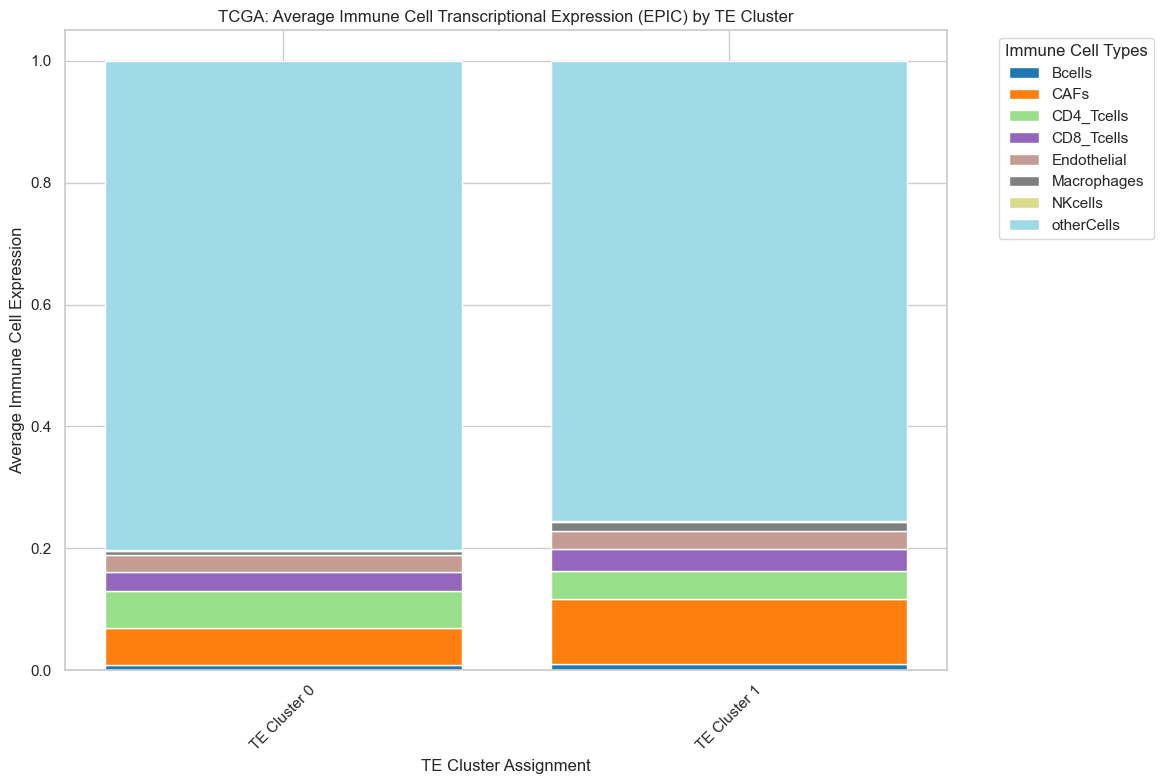

In [ ]:
TE_subtype_order = [0, 1]
cell_type_order = TCGA_EPIC_cf.columns.values.tolist()

PURE_CIBERSORT_sorted = TCGA_EPIC_cf.set_index('cluster').loc[TE_subtype_order].reset_index()

TE_reg = PURE_CIBERSORT_sorted['cluster']
data_to_plot = PURE_CIBERSORT_sorted.drop(columns=['cluster'])

existing_cell_types = [col for col in cell_type_order if col in data_to_plot.columns]
data_to_plot = data_to_plot[existing_cell_types]

TE_reg_means = data_to_plot.groupby(TE_reg).mean()

TE_reg_means = TE_reg_means.loc[TE_subtype_order]

num_colors = len(existing_cell_types)
colors = plt.get_cmap('tab20', num_colors).colors

color_dict = {cell_type: colors[i % num_colors] for i, cell_type in enumerate(existing_cell_types)}

fig, ax = plt.subplots(figsize=(14, 8))

bottom = np.zeros(len(TE_reg_means))

for col in existing_cell_types:
    ax.bar(TE_reg_means.index, TE_reg_means[col], bottom=bottom, color=color_dict[col], label=col)
    bottom += TE_reg_means[col]

plt.title('TCGA: Average Immune Cell Transcriptional Expression (EPIC) by TE Cluster')

ax.set_xticks(range(len(TE_reg_means.index)))
ax.set_xticklabels(['TE Cluster 0', 'TE Cluster 1'], rotation=45)

ax.set_xlabel('TE Cluster Assignment')
ax.set_ylabel('Average Immune Cell Expression')

ax.legend(title='Immune Cell Types', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout(rect=[0, 0, 0.85, 1])

plt.show()

In [ ]:
results = []

# 1. Perform t-tests for each cell type and store the results
for celltype in data_to_plot.columns:
    # Extract the data for each cluster
    cluster1 = TCGA_EPIC_cf.loc[TCGA_EPIC_cf['cluster'] == 0, celltype]
    cluster2 = TCGA_EPIC_cf.loc[TCGA_EPIC_cf['cluster'] == 1, celltype]
    
    # Perform the independent t-test
    ttest_12 = scipy.stats.ttest_ind(cluster1, cluster2, equal_var=False)
    
    # Append the results to the list
    results.append({
        'celltype': celltype,
        't_stat': ttest_12.statistic,
        'p_value_raw': ttest_12.pvalue
    })

# 2. Convert the results to a DataFrame
results_df = pd.DataFrame(results)

# 3. Check for any NaN p-values and handle them
num_nans = results_df['p_value_raw'].isnull().sum()
print(f"Number of NaN p-values: {num_nans}")

if num_nans > 0:
    # Optionally, inspect which celltype(s) have NaN p-values
    nan_rows = results_df[results_df['p_value_raw'].isnull()]
    print("Cell types with NaN p-values:")
    print(nan_rows)
    
    # Remove rows with NaN p-values before correction
    results_df = results_df.dropna(subset=['p_value_raw'])

# 4. Apply multiple-testing correction (Benjamini–Hochberg FDR)
reject, pvals_adj, _, _ = multipletests(results_df['p_value_raw'], method='fdr_bh')

# Add the adjusted p-values and significance flags to the DataFrame
results_df['p_value_adj'] = pvals_adj
results_df['significant'] = reject

# 5. Filter and print the significant results
significant_results = results_df[results_df['p_value_adj'] < 0.05]

print("\nSignificant immune cell markers after FDR correction:")
for index, row in significant_results.iterrows():
    print(f"{row['celltype']}: t_stat = {row['t_stat']:.2f}, adjusted p-value = {row['p_value_adj']:.4f}")

Number of NaN p-values: 0

Significant immune cell markers after FDR correction:
CAFs: t_stat = -3.74, adjusted p-value = 0.0009
CD4_Tcells: t_stat = 4.42, adjusted p-value = 0.0001
Macrophages: t_stat = -3.36, adjusted p-value = 0.0018
otherCells: t_stat = 3.54, adjusted p-value = 0.0013


### UROMOL

In [ ]:
UROMOL_EPIC_RESULTS_LIST = []

for i in range(0,5):
    UROMOL_EPIC_RESULTS_LIST.append(pd.read_csv(f'/Users/andrewgarven/Desktop/Transposons_Exp_BLCA/datasets/EPIC_results/UROMOL/UROMOL-{i}.txt', sep='\t', index_col='sampleID'))

UROMOL_EPIC_CF = pd.concat(UROMOL_EPIC_RESULTS_LIST, axis=0)

In [ ]:
UROMOL_cluster = pd.read_csv('/Users/andrewgarven/Desktop/Transposons_Exp_BLCA/datasets/UROMOL_clustering_results.csv', index_col=0)
UROMOL_EPIC_CF['cluster'] = UROMOL_cluster['Cluster_pred']

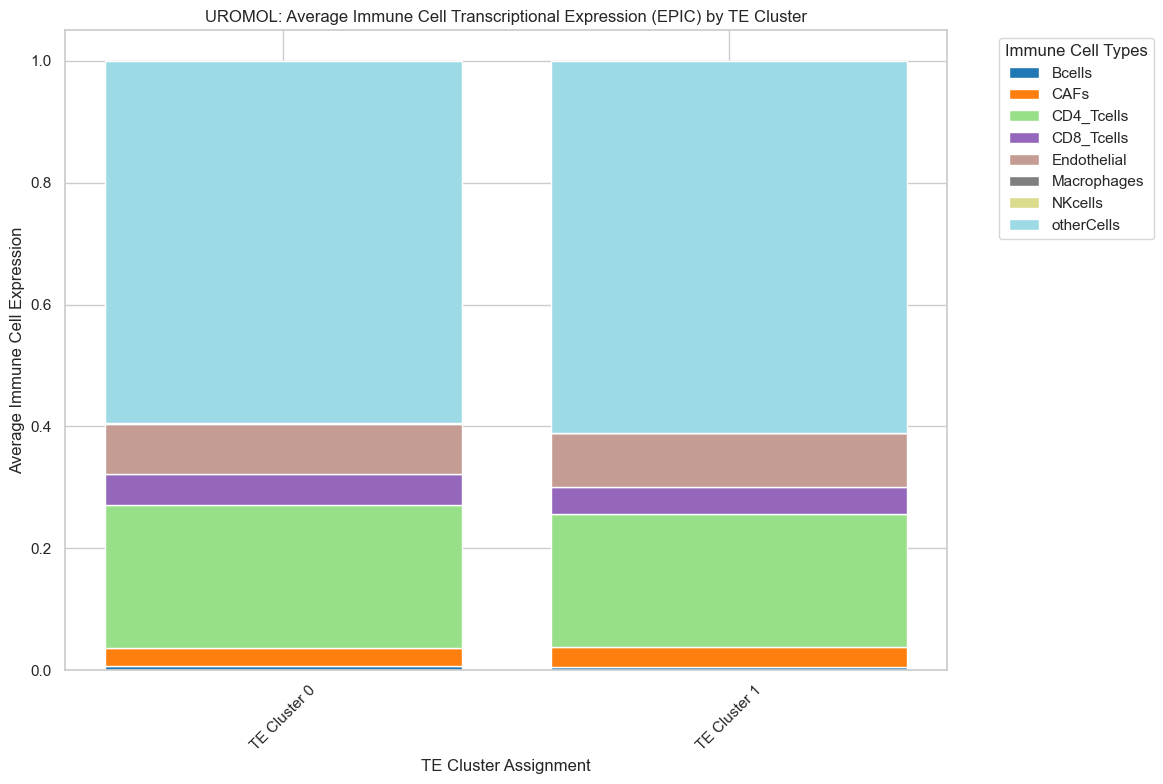

In [ ]:
TE_subtype_order = [0, 1]
cell_type_order = UROMOL_EPIC_CF.columns.values.tolist()

PURE_CIBERSORT_sorted = UROMOL_EPIC_CF.set_index('cluster').loc[TE_subtype_order].reset_index()

TE_reg = PURE_CIBERSORT_sorted['cluster']
data_to_plot = PURE_CIBERSORT_sorted.drop(columns=['cluster'])

existing_cell_types = [col for col in cell_type_order if col in data_to_plot.columns]
data_to_plot = data_to_plot[existing_cell_types]

TE_reg_means = data_to_plot.groupby(TE_reg).mean()

TE_reg_means = TE_reg_means.loc[TE_subtype_order]

num_colors = len(existing_cell_types)
colors = plt.get_cmap('tab20', num_colors).colors

color_dict = {cell_type: colors[i % num_colors] for i, cell_type in enumerate(existing_cell_types)}

fig, ax = plt.subplots(figsize=(14, 8))

bottom = np.zeros(len(TE_reg_means))

for col in existing_cell_types:
    ax.bar(TE_reg_means.index, TE_reg_means[col], bottom=bottom, color=color_dict[col], label=col)
    bottom += TE_reg_means[col]

plt.title('UROMOL: Average Immune Cell Transcriptional Expression (EPIC) by TE Cluster')

ax.set_xticks(range(len(TE_reg_means.index)))
ax.set_xticklabels(['TE Cluster 0', 'TE Cluster 1'], rotation=45)

ax.set_xlabel('TE Cluster Assignment')
ax.set_ylabel('Average Immune Cell Expression')

ax.legend(title='Immune Cell Types', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout(rect=[0, 0, 0.85, 1])

plt.show()

In [ ]:
results = []

# 1. Run t-tests for each cell type and store p-values
for celltype in data_to_plot.columns:
    cluster1 = UROMOL_EPIC_CF.loc[UROMOL_EPIC_CF['cluster'] == 0, celltype]
    cluster2 = UROMOL_EPIC_CF.loc[UROMOL_EPIC_CF['cluster'] == 1, celltype]

    ttest_12 = scipy.stats.ttest_ind(cluster1, cluster2, equal_var=False)
    
    results.append({
        'celltype': celltype,
        't_stat': ttest_12.statistic,
        'p_value_raw': ttest_12.pvalue
    })

# 2. Convert results to a DataFrame for convenience
results_df = pd.DataFrame(results)

results_df = results_df.dropna(subset=['p_value_raw'])

# 3. Apply multiple testing correction using the Benjamini–Hochberg (FDR) method
reject_list, pvals_adj, _, _ = multipletests(results_df['p_value_raw'], method='fdr_bh')
results_df['p_value_adj'] = pvals_adj
results_df['reject_null'] = reject_list  # Boolean: True if significant at alpha by BH

# 4. Optionally, filter for significant results or print them
sig_results = results_df[results_df['reject_null'] == True]

# Print only those that remain significant after adjustment
print("\nSignificant after BH correction:")
print(sig_results)



Significant after BH correction:
     celltype    t_stat  p_value_raw  p_value_adj  reject_null
3  CD8_Tcells  3.711109      0.00027      0.00189         True


### PURE-01

In [ ]:
PURE_EPIC_cf = pd.read_csv('/Users/andrewgarven/Desktop/Transposons_Exp_BLCA/datasets/EPIC_results/EPIC_PURE_CF.csv', index_col=0)
PURE_EPIC_cf.index = PURE_EPIC_cf.index.str.split('_').str[0].unique()

In [ ]:
PURE_cluster = pd.read_csv('/Users/andrewgarven/Desktop/Transposons_Exp_BLCA/datasets/PURE01_clustering_results.csv', index_col=0)
PURE_EPIC_cf['cluster'] = PURE_cluster['Cluster_pred']

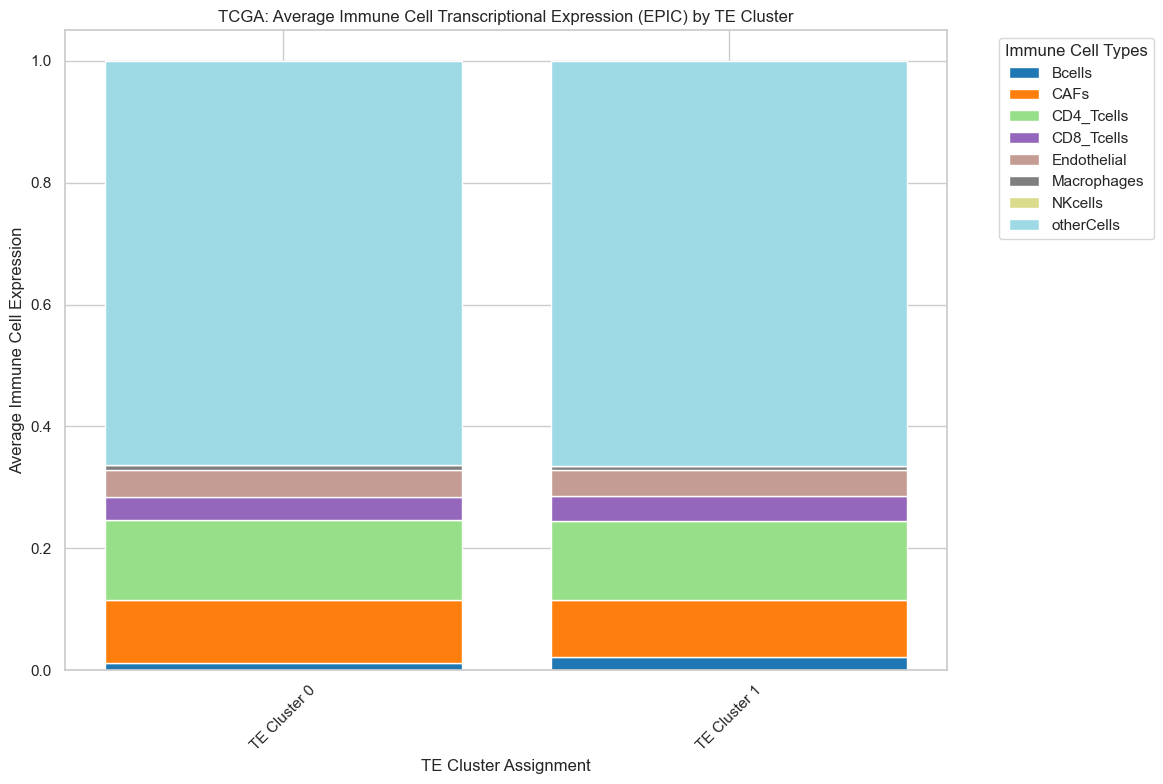

In [ ]:
TE_subtype_order = [0, 1]
cell_type_order = TCGA_EPIC_cf.columns.values.tolist()

PURE_CIBERSORT_sorted = PURE_EPIC_cf.set_index('cluster').loc[TE_subtype_order].reset_index()

TE_reg = PURE_CIBERSORT_sorted['cluster']
data_to_plot = PURE_CIBERSORT_sorted.drop(columns=['cluster'])

existing_cell_types = [col for col in cell_type_order if col in data_to_plot.columns]
data_to_plot = data_to_plot[existing_cell_types]

TE_reg_means = data_to_plot.groupby(TE_reg).mean()

TE_reg_means = TE_reg_means.loc[TE_subtype_order]

num_colors = len(existing_cell_types)
colors = plt.get_cmap('tab20', num_colors).colors

color_dict = {cell_type: colors[i % num_colors] for i, cell_type in enumerate(existing_cell_types)}

fig, ax = plt.subplots(figsize=(14, 8))

bottom = np.zeros(len(TE_reg_means))

for col in existing_cell_types:
    ax.bar(TE_reg_means.index, TE_reg_means[col], bottom=bottom, color=color_dict[col], label=col)
    bottom += TE_reg_means[col]

plt.title('TCGA: Average Immune Cell Transcriptional Expression (EPIC) by TE Cluster')

ax.set_xticks(range(len(TE_reg_means.index)))
ax.set_xticklabels(['TE Cluster 0', 'TE Cluster 1'], rotation=45)

ax.set_xlabel('TE Cluster Assignment')
ax.set_ylabel('Average Immune Cell Expression')

ax.legend(title='Immune Cell Types', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout(rect=[0, 0, 0.85, 1])

plt.show()

In [ ]:
for celltype in data_to_plot.columns: 
    cluster1 = PURE_EPIC_cf.loc[PURE_EPIC_cf['cluster'] == 0, celltype]
    cluster2 = PURE_EPIC_cf.loc[PURE_EPIC_cf['cluster'] == 1, celltype]

    ttest_12 = scipy.stats.ttest_ind(cluster1, cluster2, equal_var=False)

    if ttest_12.pvalue < 0.05:
        print(f"{celltype}: p-value = {ttest_12.pvalue}")
    else:
        print('No Significant Results')

No Significant Results
No Significant Results
No Significant Results
No Significant Results
No Significant Results
No Significant Results
No Significant Results
No Significant Results


## Differential Methylation Analysis

In [3]:
rmsk = pd.read_csv('/Users/andrewgarven/Desktop/BladderCancerTransposableElements/InputData/ReferenceData/rmsk_annotation.csv')

In [5]:
prognostic_TEs = ['AluJo',
                  'MER4B',
                  'MER136',
                  'AluYf1',
                  'SVA_A',
                  'MER66A',
                  'HSMAR1',
                  'LTR24',
                  'LTR1F1',
                  'MER61E',
                  'MER66C',
                  'AluYg6',
                  'LTR27B',
                  'LTR73',
                  'AluJr',
                  'Charlie8']

all_idx_list = []

for TE in prognostic_TEs:
    temp = rmsk[rmsk['repName'] == TE]['idx']
    all_idx_list.append(temp)

all_idx_flat = pd.concat(all_idx_list, ignore_index=True)

cleaned_idx = all_idx_flat.str.split(",").str[0].drop_duplicates().reset_index(drop=True)

cleaned_idx_list = cleaned_idx.tolist()

In [9]:
with open("te_locations.txt", "w") as f:
    for loc in cleaned_idx_list:
        f.write(loc + "\n")